# Purpose of Notebook

The goal of this code is to investigate deep mixing with Red Giants.
- The mass used will be generated using a Random Forest Model

The steps that will need to be taken in order to investigate deep mixing
1.  Compute Carbon to Nitrogen Ratio for Red Giants $$ \Big[\frac{C}{N}\Big] = \Big[\frac{C}{Fe}\Big] - \Big[\frac{N}{Fe}\Big] $$
2.  Determine which stars are Red Giants
    - To achieve this, we will need to graph `log(g)` vs `teff` to create a HR diagram
    - Using the HR diagram, we will then determine the Red Giants

3.  Separate Stars into bins and measure the amount of deep mixing in each

## Expected Results
We should see the deep mixing decreases as a function of mass and metallicity.
- Which of the two factors are more significant remains to be seen.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from statistics import mean

In [2]:
galah = pd.read_csv("ProcessedData/galah_with_mass.csv")

# 1. Compute Relative Abundance of Carbon to Nitrogen

In [3]:
galah["c_n"] = galah.c_fe - galah.n_fe

# 2. Find the !(Blue Midgets)

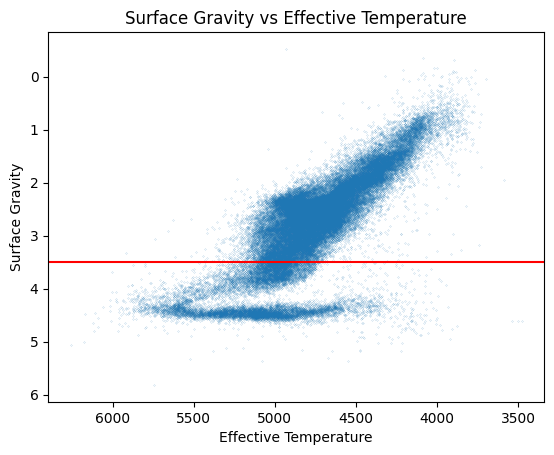

In [22]:
figure = plt.plot(
    galah.teff,
    galah.logg,
    '.',
    markersize=0.2,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Effective Temperature")
# The Cutoff is round
plt.axhline(y=3.5, color='r', linestyle='-')

In [23]:
red_giants_galah = galah.query("logg < 3.5")
red_giants_galah.to_csv("ProcessedData/galah_red_giant.csv", index=False)

# 3. Investigate Deep Mixing as a function of Mass and Metallicity

In [24]:
fe_h_range = [0.25, -0.25, -0.75, -1.25, -1.75, -4]
mass_range = [0.5, 1, 1.25, 1.5, 2.2, 4.0]
# Approximate position of RGBb
rgbbedge = [[2.666, 2.661, 2.654, 2.587, 2.50],
            [2.509, 2.500, 2.432, 2.456, 2.4],
            [2.301, 2.277, 2.222, 2.186, 2.1],
            [2.106, 2.060, 2.036, 2.098, 2.0],
            [1.953, 1.895, 1.881, 1.846, 1.8]]

TypeError: cannot unpack non-iterable PathCollection object

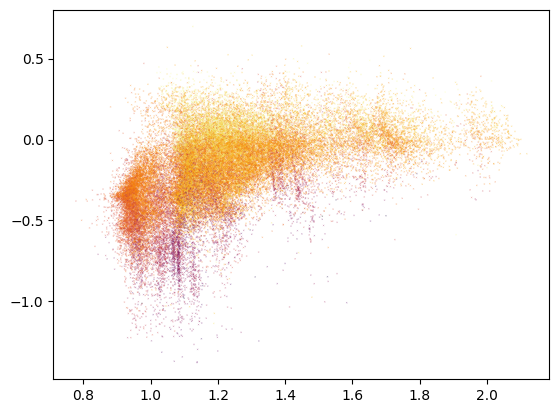

In [25]:
fig, ax = plt.scatter(red_giants_galah.mass, red_giants_galah.fe_h, marker='x', linewidths=0.1,
                      c=red_giants_galah.logg, cmap=plt.cm.inferno, s=1)
plt.xlabel("$M_{pred} (M_\odot)$")
plt.ylabel("[$Fe/H$]")

In [26]:
deep_mixing_measurement = pd.DataFrame(columns=["gradient", "avg_mass", "avg_fe_h"])

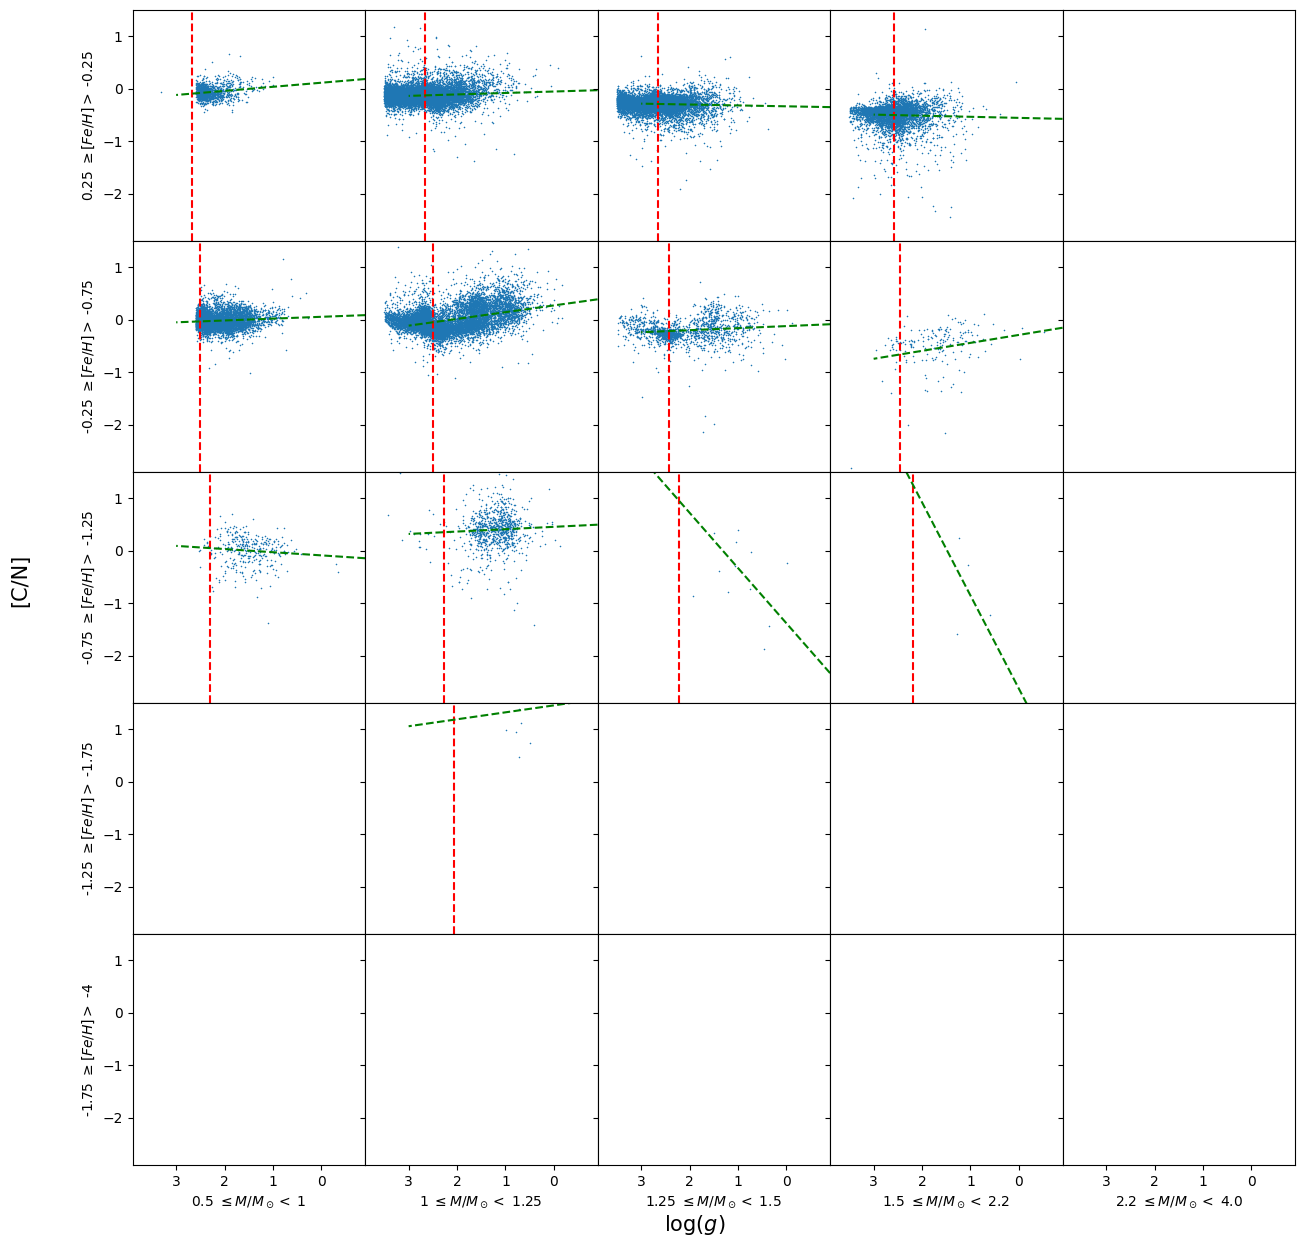

In [27]:
figure, axis = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=(15, 15),
    sharex=True,
    sharey=True
)

figure.subplots_adjust(hspace=0)
figure.subplots_adjust(wspace=0)
figure.text(0.5, 0.07, "$\log(g)$", ha="center", va="center", fontsize=15)
figure.text(0.05, 0.5, "[C/N]", ha="center", va="center", rotation="vertical",fontsize=15)
plt.axis([3.9, -0.9, -2.9, 1.5])

index = 0
# Populate each part of the graph
for i in range(0, 5): # Iterate over metallicity
    for j in range(0, 5): # Iterate over mass
        bin = red_giants_galah[
            (red_giants_galah.mass >= mass_range[j]) & (red_giants_galah.mass < mass_range[j + 1]) & (red_giants_galah.fe_h <= fe_h_range[i]) & (red_giants_galah.fe_h > fe_h_range[i + 1])
            ]
        # Labels
        axis[i, j].set_xlabel(f"{mass_range[j]} $\leq M/M_\odot <$ {mass_range[j+1]}")
        if (j == 0):
            axis[i, j].set_ylabel(f"{fe_h_range[i]} $\geq [Fe/H] >$ {fe_h_range[i+1]}")
        if (len(bin.mass) == 0): continue
        # Plot the data and where deep mixing should occur
        axis[i, j].plot(bin.logg, bin.c_n,"x", markersize=.5)
        axis[i, j].axvline(x=rgbbedge[i][j], color='r', linestyle='--')
        # Find the Polynomial Function that tracks change in C/N
        poly_model = LinearRegression()
        poly_model.fit(
            np.array(bin.logg).reshape((-1, 1)),
            np.array(bin.c_n)
        )
        X = np.arange(-1, 3, 0.001).reshape((-1, 1))
        y = poly_model.predict(X)
        axis[i, j].plot(X, y, "--", markersize=.5, color='g')
        # Compute the gradient
        y_gradient = poly_model.predict(np.array([0, 1]).reshape((-1, 1)))
        gradient = y_gradient[0] - y_gradient[1]
        avg_mass = mean(bin.mass)
        avg_fe_h = mean(bin.fe_h)
        deep_mixing_measurement.loc[index] = [gradient, avg_mass, avg_fe_h]
        index = index + 1
